# Srtucted Part

## Replicate results from HW3 using fasttext

In [ ]:
# Download and extract the data and learn_decoder.py
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
!unzip files.zip
!rm files.zip

--2022-06-29 14:58:48--  https://docs.google.com/uc?export=download&confirm=t&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56
Resolving docs.google.com (docs.google.com)... 142.251.2.100, 142.251.2.101, 142.251.2.139, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/862r8r9o88nqdkqh6s5gber5d03uq2ho/1656514725000/01333689271208460322/*/1xZaorRH-xxjfochvSesAhOTUg82_Xq56?e=download [following]
--2022-06-29 14:58:49--  https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/862r8r9o88nqdkqh6s5gber5d03uq2ho/1656514725000/01333689271208460322/*/1xZaorRH-xxjfochvSesAhOTUg82_Xq56?e=download
Resolving doc-0g-54-docs.googleusercontent.com (doc-0g-54-docs.googleusercontent.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to doc-0g-54-docs.googleusercontent.com (doc-0g-54-docs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!/usr/bin/env python
""" learn_decoder """
import sys
import pandas as pd
import numpy as np
import sklearn.linear_model

def read_matrix(filename, sep=","):
    lines = []
    with open(filename) as infile:
        for line in infile:
            lines.append(list(map(float, line.strip().split(sep))))
    return np.array(lines)

# data = read_matrix("imaging_data.csv", sep=",")
data = pd.read_csv("/content/drive/MyDrive/neuralData_for_EXP1.csv")
np_data = data.to_numpy()
data = np_data[:,1:] #(180, 185866)
glove_vectors = read_matrix("vectors_180concepts.GV42B300.txt", sep=" ")

def learn_decoder(data, vectors):
     """ Given data (a CxV matrix of V voxel activations per C concepts)
     and vectors (a CxD matrix of D semantic dimensions per C concepts)
     find a matrix M such that the dot product of M and a V-dimensional 
     data vector gives a D-dimensional decoded semantic vector. 

     The matrix M is learned using ridge regression:
     https://en.wikipedia.org/wiki/Tikhonov_regularization
     """
     ridge = sklearn.linear_model.RidgeCV(
         alphas=[1, 10, .01, 100, .001, 1000, .0001, 10000, .00001, 100000, .000001, 1000000],
         fit_intercept=False
     )
     ridge.fit(data, vectors)
     return ridge.coef_.T

In [ ]:
concepts = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U')) #The names of the 180 concepts

In [ ]:
import gensim.downloader
embedding_vectors = gensim.downloader.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
import numpy as np
fasttext_vectors = []
counter = 0
for concept in concepts:
  try:
    fasttext_vectors.append(embedding_vectors.wv[concept])
  except:
    counter += 1
    fasttext_vectors.append(embedding_vectors.wv['unk'])
fasttext_vectors = np.array(fasttext_vectors)
print(f'The number of words that out of vocabulary is: {counter}')

The number of words that out of vocabulary is: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [ ]:
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(x: np.ndarray, y: np.ndarray) -> float:
  result = dot(x, y)/(norm(x)*norm(y))
  return result

In [ ]:
rank_list = []
avg_rank_list = []
v_idx = 0

for num_fold in range(0, len(data), 10):

  data_test_set = data[num_fold:num_fold+10]
  vector_test_set = fasttext_vectors[num_fold:num_fold+10]
  data_train_set = data[0:num_fold]
  data_train_set = np.concatenate((data_train_set,data[num_fold+10:]))
  vectors_train_set = fasttext_vectors[0:num_fold]
  vectors_train_set = np.concatenate((vectors_train_set,fasttext_vectors[num_fold+10:]))

  M = learn_decoder(data_train_set, vectors_train_set)
  
  tmp_rank = 0
  for i in range(10):
    v = vector_test_set[i]
    v_hat = np.dot(data_test_set[i], M)
    similarity_list = []
    for j in range(180):
      similarity_list.append(((cosine_similarity(v_hat, fasttext_vectors[j])), j))
    similarity_list = sorted(similarity_list, key = lambda x: x[0], reverse = True)
    rank = [x+1 for x, y in enumerate(similarity_list) if y[1] == v_idx] # add 1 because he start ranking from 0
    rank_list.append((rank[0], v_idx)) 
    tmp_rank += rank[0]
    v_idx += 1 
  avg_rank = tmp_rank/10
  avg_rank_list.append(avg_rank)

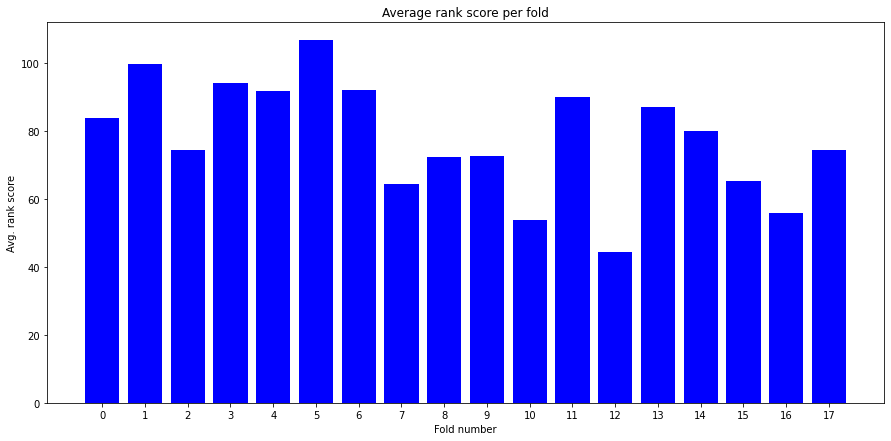

In [ ]:
import matplotlib.pyplot as plt
#TODO  

folds_list = [i for i in range(18)]

fig = plt.figure(figsize = (15, 7))

plt.bar(folds_list, avg_rank_list, color ='blue', tick_label=[str(i) for i in range(18)])

plt.xlabel("Fold number")
plt.ylabel("Avg. rank score")
plt.title("Average rank score per fold")
plt.show()

In [ ]:
#TODO 

sorted_rank = sorted(rank_list, key = lambda x: x[0], reverse = True)

best_10 = sorted_rank[:10]
worst_10 = sorted_rank[-10:]

best_concepts = []
for i in best_10:
  best_concepts.append(concepts[i[1]])
print("The 10 best concepts are:")
print(best_concepts)

worst_concepts = []
for i in worst_10:
  worst_concepts.append(concepts[i[1]])
print("The 10 worst concepts are:")
print(worst_concepts)

The 10 best cpncepts are:
['sew', 'deceive', 'emotionally', 'laugh', 'dedication', 'liar', 'electron', 'apartment', 'pig', 'smiling']
The 10 worst cpncepts are:
['play', 'bag', 'great', 'star', 'useless', 'silly', 'garbage', 'ship', 'device', 'food']


In [ ]:
total_avg = 0
for avg in avg_rank_list:
  total_avg += avg
total_avg = total_avg/18

print(f'The total average rank score is: {total_avg}')

The total average rank score is: 78.03333333333333


## Exmine trained model from HW3 (with neccesary changes) on datasets 2 & 3

In [ ]:
M = learn_decoder(data, glove_vectors)
# M

In [ ]:
#Save locally (on the left side in the pane) a .npy file
np.save("M_hw3", M)

#Important! Move the file to permanent directory in google drive
!cp -r '/content/M_hw3.npy' /content/drive/MyDrive #arg1= current full path. arg2=new directory


In [ ]:
#UPLOADING:
uploaded_decoder = np.load("/content/drive/MyDrive/M_hw3.npy")
if uploaded_decoder.shape == (185866, 300):
  print("Succeed")

Succeed


In [ ]:
import pickle

In [ ]:
import sys

import numpy as np
import sklearn.linear_model

def read_matrix(filename, sep=","):
    lines = []
    with open(filename) as infile:
        for line in infile:
            lines.append(list(map(float, line.strip().split(sep))))
    return np.array(lines)

In [ ]:
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(x: np.ndarray, y: np.ndarray) -> float:
  result = dot(x, y)/(norm(x)*norm(y))
  return result

### Experiement 2

In [ ]:
with open('/content/drive/MyDrive/EXP2.pkl', 'rb') as f: 
	data2 = pickle.load(f)

glove_vectors2 = read_matrix("/content/drive/MyDrive/vectors_384sentences.GV42B300.average.txt", sep=" ")

In [ ]:
res2 = np.dot(data2['Fmridata'], uploaded_decoder)

In [ ]:
rank_list2 = []
# avg_rank_list = []
v_idx2 = 0

tmp_rank2 = 0
for i in range(384):
  v_hat = res2[i]
  similarity_list = []
  for j in range(384):
    similarity_list.append(((cosine_similarity(v_hat, glove_vectors2[j])), j))
  similarity_list = sorted(similarity_list, key = lambda x: x[0], reverse = True)
  rank = [x+1 for x, y in enumerate(similarity_list) if y[1] == v_idx2] # add 1 because he start ranking from 0
  rank_list2.append((rank[0], v_idx2)) 
  tmp_rank2 += rank[0]
  v_idx2 += 1 
avg_rank2 = tmp_rank2/384
# avg_rank_list.append(avg_rank)

In [ ]:
avg_rank2

156.92708333333334

### Experiement 3

In [ ]:
with open('/content/drive/MyDrive/EXP3.pkl', 'rb') as f: 
	data3 = pickle.load(f)

glove_vectors3 = read_matrix("/content/drive/MyDrive/vectors_243sentences.GV42B300.average.txt", sep=" ")

In [ ]:
res3 = np.dot(data3['Fmridata'], uploaded_decoder)

In [ ]:
rank_list3 = []
# avg_rank_list = []
v_idx3 = 0

tmp_rank3 = 0
for i in range(243):
  v_hat = res3[i]
  similarity_list = []
  for j in range(243):
    similarity_list.append(((cosine_similarity(v_hat, glove_vectors3[j])), j))
  similarity_list = sorted(similarity_list, key = lambda x: x[0], reverse = True)
  rank = [x+1 for x, y in enumerate(similarity_list) if y[1] == v_idx3] # add 1 because he start ranking from 0
  rank_list3.append((rank[0], v_idx3)) 
  tmp_rank3 += rank[0]
  v_idx3 += 1 
avg_rank3 = tmp_rank3/243
# avg_rank_list.append(avg_rank)

In [ ]:
avg_rank3

100.7448559670782

## Analyzing the results 

In [ ]:
import pandas as pd

### Experiement 2

In [ ]:
topics_ids2 = []
for i in range(384):
  passage_id = data2['labelsPassageForEachSentence'][i]
  topic_id = data2['labelsPassageCategory'][passage_id-1]
  topics_ids2.append(topic_id[0][0])

In [ ]:
sen_num2 = [x[1] for x in rank_list2]
rank2 = [x[0] for x in rank_list2]

In [ ]:
df2 = pd.DataFrame({'sen num': sen_num2, 'rank': rank2, 'topic_id': topics_ids2})

In [ ]:
topic_rank2 = df2.groupby('topic_id', as_index=False)['rank'].mean()

In [ ]:
topic_name2 = list(data2['keyPassageCategory'])
topic_name2 = [topic_name2[0][i][0] for i in range(len(topic_name2[0]))]
topic_rank2['topic_name'] = topic_name2
topic_rank2 = topic_rank2.sort_values(by=['rank'])
topic_rank2

,topic_id,rank,topic_name
3,4,70.4375,body_part
13,14,92.7500,human
8,9,98.9375,drink_non_alcoholic
9,10,113.6875,dwelling
1,2,113.7500,appliance
12,13,131.8750,furniture
15,16,141.2500,kitchen_utensil
7,8,149.3125,disaster
10,11,152.3750,fish
20,21,153.0625,tool


### Experiement 3

In [ ]:
topics_ids3 = []
for i in range(243):
  passage_id = data3['labelsPassageForEachSentence'][i]
  topic_id = data3['labelsPassageCategory'][passage_id-1]
  topics_ids3.append(topic_id[0][0])

In [ ]:
sen_num3 = [x[1] for x in rank_list3]
rank3 = [x[0] for x in rank_list3]

In [ ]:
df3 = pd.DataFrame({'sen num': sen_num3, 'rank': rank3, 'topic_id': topics_ids3})

In [ ]:
topic_rank3 = df3.groupby('topic_id', as_index=False)['rank'].mean()

In [ ]:
topic_name3 = list(data3['keyPassageCategory'])
topic_name3 = [topic_name3[0][i][0] for i in range(len(topic_name3[0]))]
topic_rank3['topic_name'] = topic_name3
topic_rank3 = topic_rank3.sort_values(by=['rank'])
topic_rank3

,topic_id,rank,topic_name
6,7,52.800000,dreams
21,22,58.200000,stress
4,5,59.100000,castle
13,14,63.636364,opera
3,4,68.090909,bone_fracture
11,12,68.200000,law_school
7,8,71.600000,gambling
22,23,78.666667,taste
15,16,80.900000,painter
17,18,81.700000,polar_bear


# Semi-Srtucted Part
## We will do the analysis of both task in this part on dataset 2

## Decoder Model

In [ ]:
import sys

import numpy as np
import sklearn.linear_model


def read_matrix(filename, sep=","):
    lines = []
    with open(filename) as infile:
        for line in infile:
            lines.append(list(map(float, line.strip().split(sep))))
    return np.array(lines)

def learn_decoder(data, vectors):
     """ Given data (a CxV matrix of V voxel activations per C concepts)
     and vectors (a CxD matrix of D semantic dimensions per C concepts)
     find a matrix M such that the dot product of M and a V-dimensional 
     data vector gives a D-dimensional decoded semantic vector. 

     The matrix M is learned using ridge regression:
     https://en.wikipedia.org/wiki/Tikhonov_regularization
     """
     ridge = sklearn.linear_model.RidgeCV(
         alphas=[1, 10, .01, 100, .001, 1000, .0001, 10000, .00001, 100000, .000001, 1000000],
         fit_intercept=False
     )
     ridge.fit(data, vectors)
     return ridge.coef_.T

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

### Glove embedding

In [ ]:
rank_list = []
avg_rank_list = []
v_idx = 0

for train_index, test_index in kf.split(data2['Fmridata']):
  X_train, X_test = data2['Fmridata'][train_index], data2['Fmridata'][test_index]
  y_train, y_test = glove_vectors2[train_index], glove_vectors2[test_index]

  M2_glove = learn_decoder(X_train, y_train)

  tmp_rank = 0
  for i in range(len(X_test)):
    v = y_test[i]
    v_hat = np.dot(X_test[i], M2_glove)
    similarity_list = []
    for j in range(384):
      similarity_list.append(((cosine_similarity(v_hat, glove_vectors2[j])), j))
    similarity_list = sorted(similarity_list, key = lambda x: x[0], reverse = True)
    rank = [x+1 for x, y in enumerate(similarity_list) if y[1] == v_idx] # add 1 because he start ranking from 0
    rank_list.append((rank[0], v_idx)) 
    tmp_rank += rank[0]
    v_idx += 1 
  avg_rank = tmp_rank/len(X_test)
  avg_rank_list.append(avg_rank)


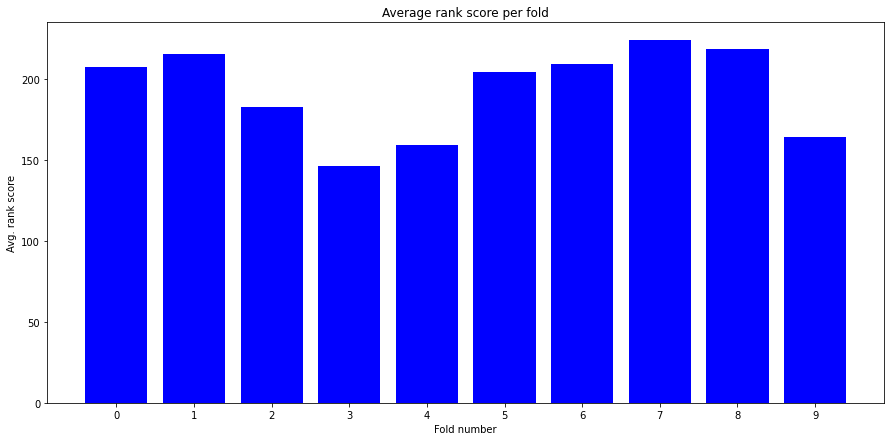

In [ ]:
import matplotlib.pyplot as plt
#TODO  

folds_list = [i for i in range(10)]

fig = plt.figure(figsize = (15, 7))

plt.bar(folds_list, avg_rank_list, color ='blue', tick_label=[str(i) for i in range(10)])

plt.xlabel("Fold number")
plt.ylabel("Avg. rank score")
plt.title("Average rank score per fold")
plt.show()

In [ ]:
total_avg = 0
for avg in avg_rank_list:
  total_avg += avg
total_avg = total_avg/10

print(f'The total average rank score is: {total_avg}')

The total average rank score is: 193.2741565452092


### Bert embedding

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 9.4 MB/s 
     |████████████████████████████████| 6.6 MB 52.8 MB/s 
     |████████████████████████████████| 101 kB 11.8 MB/s 
     |████████████████████████████████| 596 kB 32.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
sentences2 = []
for sentence in data2['keySentences']:
  sentences2.append(sentence[0][0])

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
model = AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')

# Tokenize sentences
encoded_input = tokenizer(sentences2, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling. In this case, max pooling.
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# print("Sentence embeddings:")
# print(sentence_embeddings)

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
import numpy as np
from sklearn.decomposition import PCA


sentence_embeddings_np = np.array(sentence_embeddings)
pca = PCA(n_components=300)
bert_vectors2 = pca.fit_transform(sentence_embeddings_np)
print(bert_vectors2.shape)

(384, 300)


In [ ]:
rank_list = []
avg_rank_list = []
v_idx = 0

for train_index, test_index in kf.split(data2['Fmridata']):
  X_train, X_test = data2['Fmridata'][train_index], data2['Fmridata'][test_index]
  y_train, y_test = bert_vectors2[train_index], bert_vectors2[test_index]

  M2_bert = learn_decoder(X_train, y_train)

  tmp_rank = 0
  for i in range(len(X_test)):
    v = y_test[i]
    v_hat = np.dot(X_test[i], M2_bert)
    similarity_list = []
    for j in range(384):
      similarity_list.append(((cosine_similarity(v_hat, bert_vectors2[j])), j))
    similarity_list = sorted(similarity_list, key = lambda x: x[0], reverse = True)
    rank = [x+1 for x, y in enumerate(similarity_list) if y[1] == v_idx] # add 1 because he start ranking from 0
    rank_list.append((rank[0], v_idx)) 
    tmp_rank += rank[0]
    v_idx += 1 
  avg_rank = tmp_rank/len(X_test)
  avg_rank_list.append(avg_rank)

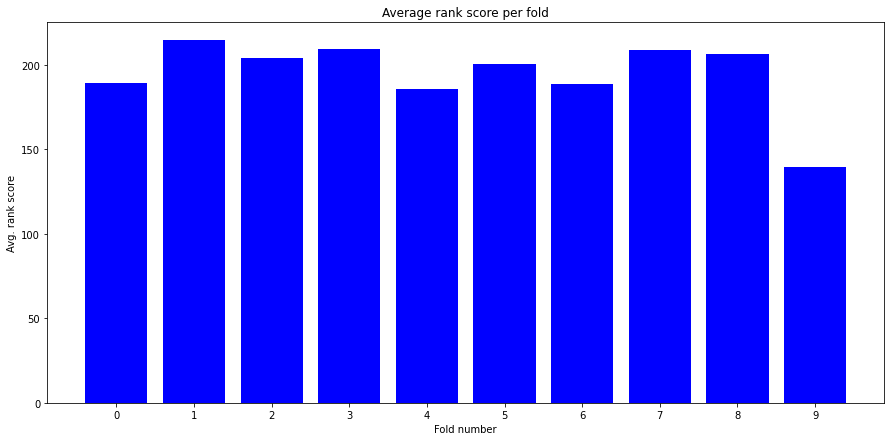

In [ ]:
import matplotlib.pyplot as plt
#TODO  

folds_list = [i for i in range(10)]

fig = plt.figure(figsize = (15, 7))

plt.bar(folds_list, avg_rank_list, color ='blue', tick_label=[str(i) for i in range(10)])

plt.xlabel("Fold number")
plt.ylabel("Avg. rank score")
plt.title("Average rank score per fold")
plt.show()

In [ ]:
total_avg = 0
for avg in avg_rank_list:
  total_avg += avg
total_avg = total_avg/10

print(f'The total average rank score is: {total_avg}')

The total average rank score is: 194.6755060728745


## Brain-encoder

In [ ]:
pip install scipy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.1 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.2.0
    Uninstalling scipy-1.2.0:
      Successfully uninstalled scipy-1.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import statsmodels.api as sm

fmri2 = data2['Fmridata']

### Glove embedding

In [ ]:
a = []
for label in range(fmri2.shape[1]):
  if label % 1000 == 0 and label != 0:
    print(label)
    significat_prop = np.mean([x[1] for x in a])
    c = []
    for x in a:
      if np.isnan(x[0]):
        continue
      c.append(x[0])
    d = np.mean(c)
    e = []
    for x in a:
      if np.isnan(x[2]):
        continue
      e.append(x[2])
    f = np.mean(e)
    print(f'The average R^2 is: {f}, The average R^2 adjusted is: {d}, The proportion of significant voxels is: {significat_prop}')
  Y = fmri2[:,label]
  X = glove_vectors2
  X = sm.add_constant(X)
  model = sm.OLS(Y,X)
  results = model.fit()
  sig = 0
  if results.f_pvalue < 0.05:
    sig = 1
  a.append((results.rsquared_adj, sig, results.rsquared))

1000
The average R^2 is: 0.807689270170019, The average R^2 adjusted is: 0.11259024668816019, The proportion of significant voxels is: 0.169
2000
The average R^2 is: 0.808343317529613, The average R^2 adjusted is: 0.11560832064869586, The proportion of significant voxels is: 0.173
3000
The average R^2 is: 0.8089178785260326, The average R^2 adjusted is: 0.11825960813819844, The proportion of significant voxels is: 0.19166666666666668
4000
The average R^2 is: 0.8082227387977968, The average R^2 adjusted is: 0.1150519151753757, The proportion of significant voxels is: 0.18925
5000
The average R^2 is: 0.8078864732203223, The average R^2 adjusted is: 0.1135002318479933, The proportion of significant voxels is: 0.1842
6000
The average R^2 is: 0.8072793175106191, The average R^2 adjusted is: 0.1106985374285195, The proportion of significant voxels is: 0.17916666666666667
7000
The average R^2 is: 0.8068401416083885, The average R^2 adjusted is: 0.10867197874714186, The proportion of significa

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1708: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


170000
The average R^2 is: 0.8036318078160056, The average R^2 adjusted is: 0.09386725775337555, The proportion of significant voxels is: 0.16538823529411764
171000
The average R^2 is: 0.8035629746207441, The average R^2 adjusted is: 0.09354962987644588, The proportion of significant voxels is: 0.16501754385964912
172000
The average R^2 is: 0.8035399611790871, The average R^2 adjusted is: 0.09344343532036571, The proportion of significant voxels is: 0.1648313953488372
173000
The average R^2 is: 0.803522741915755, The average R^2 adjusted is: 0.09336397775583319, The proportion of significant voxels is: 0.1647514450867052
174000
The average R^2 is: 0.8034528767226972, The average R^2 adjusted is: 0.09304158776859066, The proportion of significant voxels is: 0.16423563218390805
175000
The average R^2 is: 0.8034488644362752, The average R^2 adjusted is: 0.0930230732420888, The proportion of significant voxels is: 0.16403428571428572
176000
The average R^2 is: 0.8033565790072246, The avera

### Bert embedding

In [ ]:
a = []
for label in range(fmri2.shape[1]):
  if label % 1000 == 0 and label != 0:
    print(label)
    significat_prop = np.mean([x[1] for x in a])
    c = []
    for x in a:
      if np.isnan(x[0]):
        continue
      c.append(x[0])
    d = np.mean(c)
    e = []
    for x in a:
      if np.isnan(x[2]):
        continue
      e.append(x[2])
    f = np.mean(e)
    print(f'The average R^2 is: {f}, The average R^2 adjusted is: {d}, The proportion of significant voxels is: {significat_prop}')
  Y = fmri2[:,label]
  X = bert_vectors2
  X = sm.add_constant(X)
  model = sm.OLS(Y,X)
  results = model.fit()
  sig = 0
  if results.f_pvalue < 0.05:
    sig = 1
  a.append((results.rsquared_adj, sig, results.rsquared))

1000
The average R^2 is: 0.8013075869489588, The average R^2 adjusted is: 0.08314223857170117, The proportion of significant voxels is: 0.126
2000
The average R^2 is: 0.8027076186165191, The average R^2 adjusted is: 0.08960262566417833, The proportion of significant voxels is: 0.1325
3000
The average R^2 is: 0.8033853399064095, The average R^2 adjusted is: 0.09272994197776893, The proportion of significant voxels is: 0.14333333333333334
4000
The average R^2 is: 0.8037260192250362, The average R^2 adjusted is: 0.09430199232757636, The proportion of significant voxels is: 0.14775
5000
The average R^2 is: 0.8043752453618975, The average R^2 adjusted is: 0.09729781895911728, The proportion of significant voxels is: 0.1582
6000
The average R^2 is: 0.8039533817682171, The average R^2 adjusted is: 0.09535114719550752, The proportion of significant voxels is: 0.1555
7000
The average R^2 is: 0.8033333257594981, The average R^2 adjusted is: 0.09248992489021415, The proportion of significant voxe

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1708: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


170000
The average R^2 is: 0.8087755885403869, The average R^2 adjusted is: 0.11760301699961641, The proportion of significant voxels is: 0.20668823529411764
171000
The average R^2 is: 0.8088110926093458, The average R^2 adjusted is: 0.11776684902866805, The proportion of significant voxels is: 0.20665497076023392
172000
The average R^2 is: 0.8088358735407376, The average R^2 adjusted is: 0.11788119959159593, The proportion of significant voxels is: 0.2069767441860465
173000
The average R^2 is: 0.8088887296486883, The average R^2 adjusted is: 0.11812510187286214, The proportion of significant voxels is: 0.20758959537572255
174000
The average R^2 is: 0.8088970868155873, The average R^2 adjusted is: 0.11816366566710655, The proportion of significant voxels is: 0.2072528735632184
175000
The average R^2 is: 0.8089360755591896, The average R^2 adjusted is: 0.11834357758035581, The proportion of significant voxels is: 0.2078057142857143
176000
The average R^2 is: 0.8089645600951995, The aver

In this task we can see that in all measures the Bert is better than Glove. Specifically, if we focused on the proportion of the significant voxels, we could see that on Glove embedding the proportion start with increasing but then after about 70000 voxels it start decreasing to similar value that we had in the beginning but on Bert embedding it start with lower value, but it keeps increasing and in the end the proportion is higher than on Glove embedding. We could see a similar trend with adjusted R^2. The R^2 keeps the same value more or less along all iterations. 

# Open-ended Task

## clustering for dataset 1 

### Glove embedding

#### clusters with no constraints on cluster size

In [ ]:
from sklearn import metrics

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=18, random_state=42).fit(glove_vectors)
labels = kmeans.labels_
sil_score = metrics.silhouette_score(glove_vectors, labels, metric='cosine')
print(f'The silhouette score for the clustering is: {sil_score}')

cluster = kmeans.fit_predict(glove_vectors)

clusters_dict = {k: [] for k in range(18)}
for i in range(180):
  cluster_id = cluster[i]
  concept = concepts[i]
  clusters_dict[cluster_id].append(concept)

clusters_dict

The silhouette score for the clustering is: 0.02603236467881819


{0: ['ball',
  'beat',
  'big',
  'challenge',
  'crazy',
  'dance',
  'fight',
  'jungle',
  'king',
  'lady',
  'magic',
  'movie',
  'play',
  'sexy',
  'star',
  'team'],
 1: ['angry',
  'attitude',
  'elegance',
  'emotion',
  'emotionally',
  'feeling',
  'hurting',
  'laugh',
  'personality',
  'pleasure',
  'sad',
  'smiling',
  'soul'],
 2: ['apartment', 'bed', 'charming', 'residence', 'vacation'],
 3: ['bird', 'fish', 'pig', 'seafood'],
 4: ['ability',
  'accomplished',
  'body',
  'broken',
  'burn',
  'camera',
  'carefully',
  'code',
  'damage',
  'economy',
  'engine',
  'extremely',
  'flow',
  'great',
  'hair',
  'job',
  'level',
  'light',
  'material',
  'noise',
  'picture',
  'poor',
  'professional',
  'protection',
  'quality',
  'reaction',
  'read',
  'shape',
  'skin',
  'smart',
  'solution',
  'sound',
  'successful',
  'texture',
  'typical',
  'usable',
  'weak',
  'wear',
  'weather',
  'word'],
 5: ['blood', 'brain', 'disease', 'doctor', 'illness', 'me

#### clusters with equal cluster size constraint

In [ ]:
pip install k-means-constrained

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 561 kB 9.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 38.1 MB 1.1 MB/s 
     |████████████████████████████████| 15.5 MB 36.8 MB/s 
     |████████████████████████████████| 407 kB 57.7 MB/s 
  Created wheel for k-means-constrained: filename=k_means_constrained-0.7.0-cp37-cp37m-linux_x86_64.whl size=1420757 sha256=342b24be110cf80abc6b7c58b1477708a3d0191e66d4f4d188481088ee67f3ff
  Stored in directory: /root/.cache/pip/wheels/97/2e/70/c473dfd41bc709dd3c2a89ae09d345a5ffb77d1906a2a77176
Successfully built k-means-constrained
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: scipy
    Found exist

In [ ]:
from k_means_constrained import KMeansConstrained

clf = KMeansConstrained(
     n_clusters=18,
     size_min=10,
     size_max=10,
     random_state=42
)

cluster = clf.fit_predict(glove_vectors)
labels = clf.labels_

sil_score = metrics.silhouette_score(glove_vectors, labels, metric='cosine')
print(f'The silhouette score for the clustering is: {sil_score}')

cluster = clf.fit_predict(glove_vectors)

clusters_dict = {k: [] for k in range(18)}
for i in range(180):
  cluster_id = cluster[i]
  concept = concepts[i]
  clusters_dict[cluster_id].append(concept)

clusters_dict

The silhouette score for the clustering is: 0.01572281033808632


{0: ['collection',
  'construction',
  'engine',
  'job',
  'land',
  'material',
  'plant',
  'professional',
  'protection',
  'quality'],
 1: ['angry',
  'argument',
  'charming',
  'crazy',
  'laugh',
  'sad',
  'silly',
  'smart',
  'stupid',
  'useless'],
 2: ['argumentatively',
  'carefully',
  'counting',
  'deliberately',
  'dig',
  'experiment',
  'mathematical',
  'science',
  'tried',
  'willingly'],
 3: ['blood',
  'dangerous',
  'delivery',
  'disease',
  'dissolve',
  'doctor',
  'illness',
  'medication',
  'pain',
  'reaction'],
 4: ['bear',
  'bed',
  'gold',
  'jungle',
  'king',
  'mountain',
  'road',
  'tree',
  'vacation',
  'weather'],
 5: ['apartment',
  'building',
  'business',
  'code',
  'computer',
  'level',
  'plan',
  'residence',
  'ship',
  'student'],
 6: ['bar',
  'beer',
  'dessert',
  'dinner',
  'food',
  'light',
  'seafood',
  'sugar',
  'table',
  'taste'],
 7: ['ball',
  'body',
  'broken',
  'camera',
  'driver',
  'left',
  'movement',
  'p

### Bert embedding

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Load model from HuggingFace Hub
tokenizer1 = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
model1 = AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')

# Tokenize sentences
encoded_input1 = tokenizer1(list(concepts), padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output1 = model1(**encoded_input1)

# Perform pooling. In this case, max pooling.
sentence_embeddings1 = mean_pooling(model_output1, encoded_input1['attention_mask'])

# print("Sentence embeddings:")
# print(sentence_embeddings)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
kmeans = KMeans(n_clusters=18, random_state=42).fit(glove_vectors)
labels = kmeans.labels_
sil_score = metrics.silhouette_score(sentence_embeddings1, labels, metric='cosine')
print(f'The silhouette score for the clustering is: {sil_score}')

cluster = kmeans.fit_predict(sentence_embeddings1)

clusters_dict = {k: [] for k in range(18)}
for i in range(180):
  cluster_id = cluster[i]
  concept = concepts[i]
  clusters_dict[cluster_id].append(concept)

clusters_dict

The silhouette score for the clustering is: -0.10682876408100128


{0: ['ability',
  'accomplished',
  'big',
  'extremely',
  'great',
  'impress',
  'personality',
  'sexy',
  'smart',
  'successful'],
 1: ['bag',
  'beat',
  'body',
  'camera',
  'clothes',
  'code',
  'collection',
  'counting',
  'delivery',
  'dig',
  'do',
  'doctor',
  'dressing',
  'flow',
  'hair',
  'lady',
  'mountain',
  'nation',
  'picture',
  'plan',
  'read',
  'sew',
  'shape',
  'sign',
  'skin',
  'spoke',
  'team',
  'time',
  'tried',
  'wear',
  'word'],
 2: ['angry',
  'broken',
  'damage',
  'disturb',
  'garbage',
  'hurting',
  'illness',
  'pain',
  'poor',
  'sad'],
 3: ['blood', 'burn', 'cockroach', 'disease', 'dissolve', 'pig', 'sin', 'war'],
 4: ['apartment',
  'bed',
  'building',
  'king',
  'land',
  'marriage',
  'prison',
  'residence',
  'vacation'],
 5: ['attitude',
  'bird',
  'deliberately',
  'emotion',
  'emotionally',
  'feeling',
  'help',
  'medication',
  'obligation',
  'protection',
  'reaction',
  'relationship',
  'religious',
  'solu

In [ ]:
from k_means_constrained import KMeansConstrained

clf = KMeansConstrained(
     n_clusters=18,
     size_min=10,
     size_max=10,
     random_state=42
)

cluster = clf.fit_predict(sentence_embeddings1)
labels = clf.labels_

sil_score = metrics.silhouette_score(sentence_embeddings1, labels, metric='cosine')
print(f'The silhouette score for the clustering is: {sil_score}')

cluster = clf.fit_predict(glove_vectors)

clusters_dict = {k: [] for k in range(18)}
for i in range(180):
  cluster_id = cluster[i]
  concept = concepts[i]
  clusters_dict[cluster_id].append(concept)

clusters_dict

The silhouette score for the clustering is: 0.031199926510453224


{0: ['collection',
  'construction',
  'engine',
  'job',
  'land',
  'material',
  'plant',
  'professional',
  'protection',
  'quality'],
 1: ['angry',
  'argument',
  'charming',
  'crazy',
  'laugh',
  'sad',
  'silly',
  'smart',
  'stupid',
  'useless'],
 2: ['argumentatively',
  'carefully',
  'counting',
  'deliberately',
  'dig',
  'experiment',
  'mathematical',
  'science',
  'tried',
  'willingly'],
 3: ['blood',
  'dangerous',
  'delivery',
  'disease',
  'dissolve',
  'doctor',
  'illness',
  'medication',
  'pain',
  'reaction'],
 4: ['bear',
  'bed',
  'gold',
  'jungle',
  'king',
  'mountain',
  'road',
  'tree',
  'vacation',
  'weather'],
 5: ['apartment',
  'building',
  'business',
  'code',
  'computer',
  'level',
  'plan',
  'residence',
  'ship',
  'student'],
 6: ['bar',
  'beer',
  'dessert',
  'dinner',
  'food',
  'light',
  'seafood',
  'sugar',
  'table',
  'taste'],
 7: ['ball',
  'body',
  'broken',
  'camera',
  'driver',
  'left',
  'movement',
  'p

## Train on one dataset and test on other datasets

### Train on dataset 2 and test on datasets 1 & 3

#### Glove embedding

In [ ]:
M2_glove = learn_decoder(data2['Fmridata'], glove_vectors2)
M2_glove

array([[ 1.02499568e-05, -4.63731345e-07,  6.88798819e-07, ...,
         5.67431563e-06, -5.02423213e-06,  1.33972951e-07],
       [ 1.53553068e-05, -1.21916802e-06,  7.17670383e-08, ...,
         6.84795512e-06, -7.16227667e-06, -2.65457693e-07],
       [ 1.48439786e-05, -2.14683835e-06, -3.59249266e-06, ...,
         1.01224120e-05, -6.12245072e-06,  4.32878067e-07],
       ...,
       [-2.46560637e-07, -1.07924408e-06,  2.37337972e-06, ...,
         1.62773754e-06,  9.25408127e-07,  1.72059607e-05],
       [-1.39271548e-06,  6.11219561e-07,  7.25398472e-06, ...,
         1.04132829e-05,  8.76471906e-06,  8.63341036e-06],
       [ 3.03583602e-07,  5.88227449e-07,  3.36127030e-06, ...,
         1.29640896e-05,  2.57909544e-06,  1.22737528e-05]])

In [ ]:
test_set = data

glove_res = np.dot(test_set, M2_glove)

g_rank_list = []
g_v_idx = 0

g_tmp_rank = 0
for i in range(180):
  v_hat = glove_res[i]
  similarity_list = []
  for j in range(180):
    similarity_list.append(((cosine_similarity(v_hat, glove_vectors[j])), j))
  similarity_list = sorted(similarity_list, key = lambda x: x[0], reverse = True)
  rank = [x+1 for x, y in enumerate(similarity_list) if y[1] == g_v_idx] # add 1 because he start ranking from 0
  g_rank_list.append((rank[0], g_v_idx)) 
  g_tmp_rank += rank[0]
  g_v_idx += 1 
g_avg_rank = g_tmp_rank/180
g_avg_rank

80.04444444444445

In [ ]:
test_set = data3['Fmridata']

glove_res = np.dot(test_set, M2_glove)

g_rank_list3 = []
g_v_idx3 = 0

g_tmp_rank3 = 0
for i in range(243):
  v_hat = glove_res[i]
  similarity_list = []
  for j in range(243):
    similarity_list.append(((cosine_similarity(v_hat, glove_vectors3[j])), j))
  similarity_list = sorted(similarity_list, key = lambda x: x[0], reverse = True)
  rank = [x+1 for x, y in enumerate(similarity_list) if y[1] == g_v_idx3] # add 1 because he start ranking from 0
  g_rank_list3.append((rank[0], g_v_idx3)) 
  g_tmp_rank3 += rank[0]
  g_v_idx3 += 1 
g_avg_rank3 = g_tmp_rank3/243
g_avg_rank3

94.39917695473251

In [ ]:
topics_ids3 = []
for i in range(243):
  passage_id = data3['labelsPassageForEachSentence'][i]
  topic_id = data3['labelsPassageCategory'][passage_id-1]
  topics_ids3.append(topic_id[0][0])

sen_num3 = [x[1] for x in g_rank_list3]
rank3 = [x[0] for x in g_rank_list3]
df3 = pd.DataFrame({'sen num': sen_num3, 'rank': rank3, 'topic_id': topics_ids3})
topic_rank3 = df3.groupby('topic_id', as_index=False)['rank'].mean()

topic_name3 = list(data3['keyPassageCategory'])
topic_name3 = [topic_name3[0][i][0] for i in range(len(topic_name3[0]))]
topic_rank3['topic_name'] = topic_name3
topic_rank3 = topic_rank3.sort_values(by=['rank'])
topic_rank3

,topic_id,rank,topic_name
17,18,34.100000,polar_bear
22,23,50.444444,taste
9,10,57.500000,ice_cream
6,7,68.400000,dreams
11,12,71.700000,law_school
8,9,78.300000,hurricane
15,16,79.800000,painter
10,11,84.000000,infection
12,13,84.500000,lawn_mower
5,6,85.000000,computer_graphics


#### Bert embedding

In [ ]:
M2_bert = learn_decoder(data2['Fmridata'], bert_vectors2)
M2_bert

array([[ 1.61748683e-04,  1.93104849e-05,  6.82033856e-05, ...,
         5.59133602e-06,  9.90247828e-06,  7.48324948e-06],
       [ 9.86983781e-05, -3.93591232e-05,  9.63076582e-05, ...,
         4.81234102e-06,  9.73455789e-06,  9.83877868e-06],
       [ 1.08732687e-04, -5.81900663e-05,  3.35141276e-05, ...,
         6.67613071e-06,  7.53302405e-06,  9.34239616e-06],
       ...,
       [ 4.21174651e-04, -6.85857545e-05,  3.35559787e-05, ...,
        -5.42192210e-07, -2.95997870e-06, -1.63044949e-06],
       [-2.74372096e-06, -1.38651345e-05, -2.08850036e-05, ...,
         2.66684687e-06, -7.90408395e-06,  8.09168462e-06],
       [ 1.52095640e-04, -3.05257468e-05,  2.70012283e-05, ...,
        -1.51729350e-07, -9.41120251e-06,  2.88036586e-06]])

In [ ]:
test_set = data

bert_res = np.dot(test_set, M2_bert)

b_rank_list = []
b_v_idx = 0

b_tmp_rank = 0
for i in range(180):
  v_hat = bert_res[i]
  similarity_list = []
  for j in range(180):
    similarity_list.append(((cosine_similarity(v_hat, glove_vectors[j])), j))
  similarity_list = sorted(similarity_list, key = lambda x: x[0], reverse = True)
  rank = [x+1 for x, y in enumerate(similarity_list) if y[1] == b_v_idx] # add 1 because he start ranking from 0
  b_rank_list.append((rank[0], b_v_idx)) 
  b_tmp_rank += rank[0]
  b_v_idx += 1 
b_avg_rank = b_tmp_rank/180
b_avg_rank

89.37777777777778

In [ ]:
test_set = data3['Fmridata']

bert_res = np.dot(test_set, M2_bert)

b_rank_list3 = []
b_v_idx3 = 0

b_tmp_rank3 = 0
for i in range(243):
  v_hat = bert_res[i]
  similarity_list = []
  for j in range(243):
    similarity_list.append(((cosine_similarity(v_hat, glove_vectors3[j])), j))
  similarity_list = sorted(similarity_list, key = lambda x: x[0], reverse = True)
  rank = [x+1 for x, y in enumerate(similarity_list) if y[1] == b_v_idx3] # add 1 because he start ranking from 0
  b_rank_list3.append((rank[0], b_v_idx3)) 
  b_tmp_rank3 += rank[0]
  b_v_idx3 += 1 
b_avg_rank3 = b_tmp_rank3/243
b_avg_rank3

118.10288065843622

In [ ]:
topics_ids3 = []
for i in range(243):
  passage_id = data3['labelsPassageForEachSentence'][i]
  topic_id = data3['labelsPassageCategory'][passage_id-1]
  topics_ids3.append(topic_id[0][0])

sen_num3 = [x[1] for x in b_rank_list3]
rank3 = [x[0] for x in b_rank_list3]
df3 = pd.DataFrame({'sen num': sen_num3, 'rank': rank3, 'topic_id': topics_ids3})
topic_rank3 = df3.groupby('topic_id', as_index=False)['rank'].mean()

topic_name3 = list(data3['keyPassageCategory'])
topic_name3 = [topic_name3[0][i][0] for i in range(len(topic_name3[0]))]
topic_rank3['topic_name'] = topic_name3
topic_rank3 = topic_rank3.sort_values(by=['rank'])
topic_rank3

,topic_id,rank,topic_name
1,2,65.727273,beekeeping
2,3,83.200000,blindness
16,17,86.300000,pharmacist
14,15,87.200000,owl
15,16,88.600000,painter
8,9,102.600000,hurricane
4,5,103.300000,castle
13,14,106.727273,opera
6,7,107.500000,dreams
19,20,111.454545,rock_climbing


### Train on dataset 3 and test on datasets 1 & 2

#### Glove embedding

In [ ]:
M3_glove = learn_decoder(data3['Fmridata'], glove_vectors3)
M3_glove

array([[-6.11652512e-06, -1.26084073e-07,  8.35287354e-06, ...,
        -6.04298742e-06,  5.45767025e-06, -1.34440449e-05],
       [-5.28066855e-06,  2.18815179e-06,  6.17484013e-06, ...,
        -2.50596348e-06,  1.27529031e-06, -9.53853678e-06],
       [-4.50684873e-06,  5.36389981e-07,  3.77728606e-06, ...,
        -6.09592646e-08,  1.21614215e-07, -7.00201207e-06],
       ...,
       [-3.75074892e-06, -2.59400355e-06, -1.39460215e-06, ...,
        -6.04130359e-06,  1.54650421e-06, -4.25665799e-06],
       [-5.50161187e-06, -2.28973194e-06,  2.13631465e-06, ...,
        -5.32740033e-06,  2.51949743e-06, -2.88304736e-07],
       [-6.65134990e-06, -2.33545913e-06,  2.67671613e-06, ...,
        -5.02980291e-06,  1.60449340e-06, -4.60994339e-06]])

In [ ]:
test_set = data

glove_res = np.dot(test_set, M3_glove)

g_rank_list = []
g_v_idx = 0

g_tmp_rank = 0
for i in range(180):
  v_hat = glove_res[i]
  similarity_list = []
  for j in range(180):
    similarity_list.append(((cosine_similarity(v_hat, glove_vectors[j])), j))
  similarity_list = sorted(similarity_list, key = lambda x: x[0], reverse = True)
  rank = [x+1 for x, y in enumerate(similarity_list) if y[1] == g_v_idx] # add 1 because he start ranking from 0
  g_rank_list.append((rank[0], g_v_idx)) 
  g_tmp_rank += rank[0]
  g_v_idx += 1 
g_avg_rank = g_tmp_rank/180
g_avg_rank

83.45

In [ ]:
test_set = data2['Fmridata']

glove_res = np.dot(test_set, M3_glove)

g_rank_list2 = []
g_v_idx2 = 0

g_tmp_rank2 = 0
for i in range(384):
  v_hat = glove_res[i]
  similarity_list = []
  for j in range(384):
    similarity_list.append(((cosine_similarity(v_hat, glove_vectors2[j])), j))
  similarity_list = sorted(similarity_list, key = lambda x: x[0], reverse = True)
  rank = [x+1 for x, y in enumerate(similarity_list) if y[1] == g_v_idx2] # add 1 because he start ranking from 0
  g_rank_list2.append((rank[0], g_v_idx3)) 
  g_tmp_rank2 += rank[0]
  g_v_idx2 += 1 
g_avg_rank2 = g_tmp_rank2/384
g_avg_rank2

151.8125

In [ ]:
topics_ids2 = []
for i in range(384):
  passage_id = data2['labelsPassageForEachSentence'][i]
  topic_id = data2['labelsPassageCategory'][passage_id-1]
  topics_ids2.append(topic_id[0][0])

sen_num2 = [x[1] for x in g_rank_list2]
rank2 = [x[0] for x in g_rank_list2]
df2 = pd.DataFrame({'sen num': sen_num2, 'rank': rank2, 'topic_id': topics_ids2})
topic_rank2 = df2.groupby('topic_id', as_index=False)['rank'].mean()

topic_name2 = list(data2['keyPassageCategory'])
topic_name2 = [topic_name2[0][i][0] for i in range(len(topic_name2[0]))]
topic_rank2['topic_name'] = topic_name2
topic_rank2 = topic_rank2.sort_values(by=['rank'])
topic_rank2

,topic_id,rank,topic_name
9,10,88.6875,dwelling
13,14,93.5000,human
3,4,93.6250,body_part
8,9,100.5000,drink_non_alcoholic
12,13,105.1875,furniture
18,19,105.5000,place
4,5,112.0000,building_part
20,21,125.1875,tool
6,7,130.3125,crime
7,8,139.0625,disaster
